In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
from PIL import Image
from PIL import ImageFile
import requests
import shutil
import urllib
import math

# for notification after long-running code-cell
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*2)/10000)

#Now let us read metadata to get our Y values (multiple lables)
os.chdir("/Users/jonas/Documents/art-classification/")
df = pd.read_csv('data/wikiart_scraped.csv')
print(df.head())     # printing first five rows of the file
print(df.columns)
#print(df["Style"].unique())

styles = ["Abstract-Art", "Abstract-Expressionism", "Academicism", "Art-Informel", "Art-Nouveau-(Modern)", "Baroque","Cubism", "Color-Field-Painting", "Conceptual-Art", "Expressionism", "Impressionism", "Mannerism-(Late-Renaissance)", "Minimalism", "Naïve-Art-(Primitivism)", "Pop-Art", "Post-Impressionism", "Neoclassicism", "Neo-Expressionism", "Northern-Renaissance", "Realism", "Rococo", "Romanticism", "Surrealism", "Symbolism"]

df = df[df["Style"].isin(styles)]
print(df.iloc[:20])

print(df.shape)



#save images
main_dir = os.getcwd()
image_directory = os.getcwd()+"/data/img"#/new"
os.chdir(image_directory)

""" Test for a single image
img_url = "https://uploads3.wikiart.org/00265/images/ancient-egyptian-painting/narmer-palette.jpg"
img = Image.open(requests.get(img_url, stream = True).raw)
img = img.resize((300,300))
img.save("bla.jpg")
"""
"""
ImageFile.LOAD_TRUNCATED_IMAGES = True # especially in Cubism there are truncated files
for index, row in df.iterrows():
    if not os.path.exists(str(index) + ".jpg"):
        try:
            img = Image.open(requests.get(row["Link"], stream=True).raw)
            img = img.resize((300, 300))
            img.convert("RGB").save(str(index) + ".jpg")
        except:
            print("An error occured with image {} (Link: {})".format(index, row["Link"]))
Audio(wave, rate=10000, autoplay=True) # notification that execution is finished
"""

            Style                                    Artwork         Artist  \
0  Early-Dynastic                             Narmer Palette  Ancient Egypt   
1  Early-Dynastic         Box Inlay with a Geometric Pattern  Ancient Egypt   
2     Old-Kingdom                           Khafre Enthroned  Ancient Egypt   
3  Middle-Kingdom  Stele of the Serpent King (Stela of Djet)  Ancient Egypt   
4  Middle-Kingdom  Laden Donkeys and Ploughing, Tomb of Djar  Ancient Egypt   

           Date                                               Link  
0       3050 BC  https://uploads3.wikiart.org/00265/images/anci...  
1  3100-2900 BC  https://uploads2.wikiart.org/00244/images/anci...  
2       2570 BC  https://uploads2.wikiart.org/00305/images/anci...  
3       3000 BC  https://uploads7.wikiart.org/00305/images/anci...  
4  2060-2010 BC  https://uploads8.wikiart.org/00244/images/anci...  
Index(['Style', 'Artwork', 'Artist', 'Date', 'Link'], dtype='object')
                             Style       

'\nImageFile.LOAD_TRUNCATED_IMAGES = True # especially in Cubism there are truncated files\nfor index, row in df.iterrows():\n    if not os.path.exists(str(index) + ".jpg"):\n        try:\n            img = Image.open(requests.get(row["Link"], stream=True).raw)\n            img = img.resize((300, 300))\n            img.convert("RGB").save(str(index) + ".jpg")\n        except:\n            print("An error occured with image {} (Link: {})".format(index, row["Link"]))\nAudio(wave, rate=10000, autoplay=True) # notification that execution is finished\n'

In [2]:

df = df[df.Date.str.isnumeric()] # only accept numeric dates
df["Date"] = pd.to_numeric(df["Date"])
df = df[df["Date"]>=1000]
#timedelta = 10
#timesteps = range(1000, 2020, 10)

# bring style to correct format
"""
for style in styles:
    df[style] = 0 #1 if (df["Style"]==style) else 0
    df.loc[df["Style"]==style, style] = 1
"""

# split into decades / other defined timedelta

# exact year to decade
df["Date"] = df["Date"].apply(lambda x: (math.floor(x/10))*10)

df=pd.get_dummies(df, columns=["Style", "Date"])

"""
for time in timesteps:
    df[str(time)+"s"]=0
"""

"""
for index, row in df.iterrows():
    found = False
    for time in timesteps:
        if math.floor((row["Date"]/10)*10) == time:
            row[str(time)+"s"] = 1
"""

'\nfor index, row in df.iterrows():\n    found = False\n    for time in timesteps:\n        if math.floor((row["Date"]/10)*10) == time:\n            row[str(time)+"s"] = 1\n'

In [3]:

SIZE = 200
X_dataset = []
#for i in tqdm(range(df.shape[0])):
for index, row in df.iterrows():
    img = image.image_utils.load_img(image_directory + "/" + str(index) + '.jpg', target_size=(SIZE,SIZE,3))
    img = image.image_utils.img_to_array(img)
    img = img/255.
    X_dataset.append(img)
    #df.loc[index,str(row["Date"])+"s"]=1 # to_categorical would have been the easy solution


X = np.array(X_dataset)

In [4]:


#Id and Genre are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.
#y = np.array(df.drop(['Style', 'Artwork', 'Artist', 'Date', 'Link'], axis=1))
y = np.array(df.drop(['Artwork', 'Artist', 'Link'], axis=1))

print(len(X))
print(len(y))


58249
58249


In [5]:
import tensorflow as tf

os.chdir(main_dir+"/models")
csv_logger = tf.keras.callbacks.CSVLogger(os.getcwd()+"/log.csv", separator=",", append=True)
decades = [col for col in df if col.startswith("Date_")]
print(decades)

['Date_1410', 'Date_1420', 'Date_1430', 'Date_1440', 'Date_1450', 'Date_1460', 'Date_1470', 'Date_1480', 'Date_1490', 'Date_1500', 'Date_1510', 'Date_1520', 'Date_1530', 'Date_1540', 'Date_1550', 'Date_1560', 'Date_1570', 'Date_1580', 'Date_1590', 'Date_1600', 'Date_1610', 'Date_1620', 'Date_1630', 'Date_1640', 'Date_1660', 'Date_1670', 'Date_1680', 'Date_1690', 'Date_1700', 'Date_1710', 'Date_1720', 'Date_1730', 'Date_1740', 'Date_1750', 'Date_1760', 'Date_1770', 'Date_1780', 'Date_1790', 'Date_1800', 'Date_1810', 'Date_1820', 'Date_1830', 'Date_1840', 'Date_1850', 'Date_1860', 'Date_1870', 'Date_1880', 'Date_1890', 'Date_1900', 'Date_1910', 'Date_1920', 'Date_1930', 'Date_1940', 'Date_1950', 'Date_1960', 'Date_1970', 'Date_1980', 'Date_1990', 'Date_2000', 'Date_2010', 'Date_2020']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)
print(y_train)
print(len(y_train))
print(len(y_test))


In [ ]:
with open('train_data.npy', 'wb') as f:
    np.save(f, X_train)
with open('train_labels.npy', 'wb') as f:
    np.save(f, y_train)
with open('test_data.npy', 'wb') as f:
    np.save(f, X_test)
with open('test_labels.npy', 'wb') as f:
    np.save(f, y_test)

In [ ]:
y1_train = y_train[:,0:len(styles)]
y2_train = y_train[:,len(styles):]
print(y1_train.shape)
print(y2_train.shape)
y1_test = y_test[:,0:len(styles)]
y2_test = y_test[:,len(styles):]

In [ ]:
from keras import Input
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
newModel = True

if newModel:
    input_layer = Input(shape=(SIZE,SIZE,3))

    conv1 = Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(input_layer)
    bn1 = BatchNormalization()(conv1)
    mp1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    dropout1 = Dropout(0.2)(mp1)

    conv2 = Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(dropout1)
    mp2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    bn2 = BatchNormalization()(mp2)
    dropout2 = Dropout(0.2)(bn2)

    conv3 = Conv2D(filters=64, kernel_size=(5, 5), activation="relu")(dropout2)
    mp3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    bn3 = BatchNormalization()(mp3)
    dropout3 = Dropout(0.2)(bn3)

    conv4 = Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(dropout3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    bn4 = BatchNormalization()(mp4)
    dropout4 = Dropout(0.2)(bn4)

    flatten = Flatten()(dropout4)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout5 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout5)
    dropout6 = Dropout(0.5)(dense2)

    y1_output = Dense(len(styles), activation='softmax', name='style_output')(dropout6)
    y2_output = Dense(len(decades), activation='softmax', name='decade_output')(dropout6)
    #model.add(Dense(len(styles)+len(decades), activation='sigmoid')) # changed from 25 to 1 so I get no error

    model = keras.Model(inputs=input_layer, outputs=[y1_output, y2_output])

    model.summary()

    #Binary cross entropy of each label. So no really a binary classification problem but
    #Calculating binary cross entropy for each label.
    model.compile(optimizer='adam',
                  loss={'style_output':'binary_crossentropy', 'decade_output':'binary_crossentropy'},
                  metrics={'style_output':'accuracy','decade_output':'accuracy'})


    history = model.fit(X_train,
                        [y_train[:,0:len(styles)], y_train[:,len(styles):]],
                        epochs=25,
                        validation_data=(X_test, [y_test[:,0:len(styles)], y_test[:,len(styles):]]),
                        batch_size=64,
                        callbacks=[csv_logger])

    # save model
    !mkdir -p saved_model
    model.save('saved_model/my_model_with_years')

else:
    model = keras.models.load_model('saved_model/my_model_with_years')
    #history = model.evaluate(X_test, y_test, verbose=2)
    #history.history=history

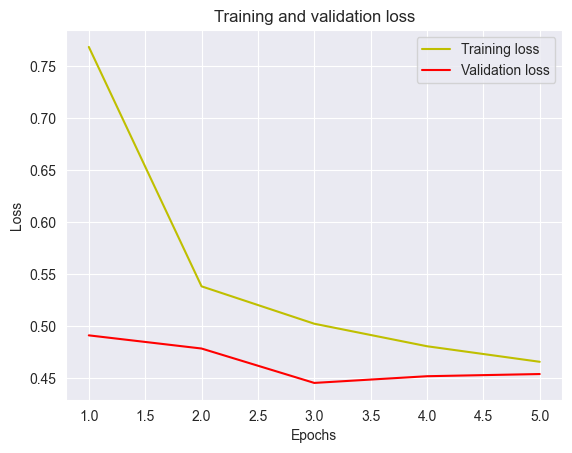

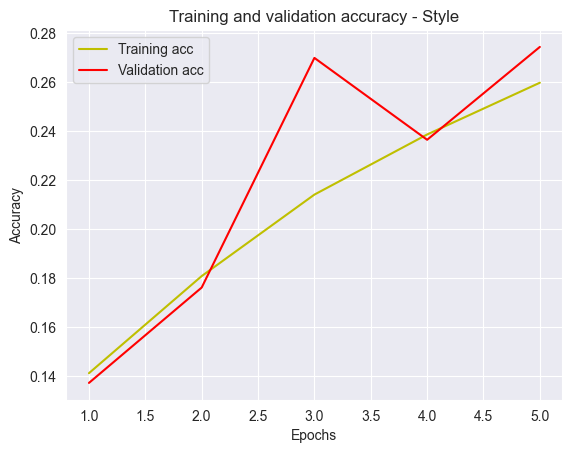

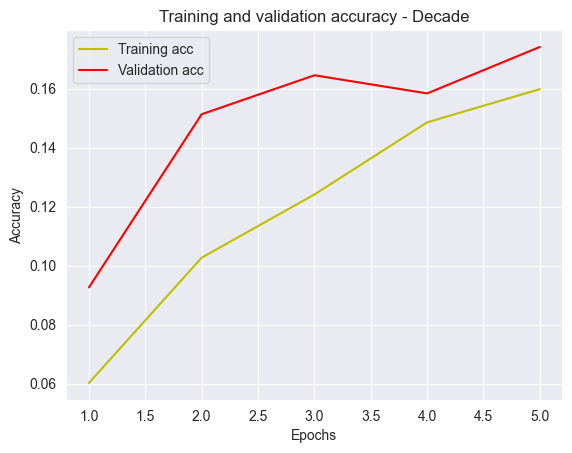

In [29]:


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc_style = history.history['style_output_accuracy']
val_acc_style = history.history['val_style_output_accuracy']
plt.plot(epochs, acc_style, 'y', label='Training acc')
plt.plot(epochs, val_acc_style, 'r', label='Validation acc')
plt.title('Training and validation accuracy - Style')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

acc_dec = history.history['decade_output_accuracy']
val_acc_dec = history.history['val_decade_output_accuracy']
plt.plot(epochs, acc_dec, 'y', label='Training acc')
plt.plot(epochs, val_acc_dec, 'r', label='Validation acc')
plt.title('Training and validation accuracy - Decade')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 [==============================] - 0s 15ms/step
[array([[0.01695376, 0.34346962, 0.05532912, 0.01607876, 0.1476241 ,
        0.0236263 , 0.01702317, 0.27601135, 0.10388384]], dtype=float32), array([[1.1486565e-05, 9.8701996e-05, 3.1206783e-04, 1.0781388e-03,
        1.8103445e-03, 4.4678813e-03, 1.1923101e-03, 9.4955276e-06,
        1.2576400e-04, 2.5465705e-03, 8.9058274e-05, 3.2734027e-04,
        1.9506871e-04, 2.8490538e-03, 1.5079710e-03, 6.5677888e-03,
        4.8973276e-03, 4.3778890e-03, 2.5323845e-04, 1.7865959e-03,
        1.2763953e-02, 4.3029740e-02, 8.3232246e-02, 6.2800907e-02,
        1.5648378e-01, 2.9338297e-01, 1.0017854e-01, 1.2015549e-01,
        5.6549396e-02, 3.6918912e-02]], dtype=float32)]


'\n'

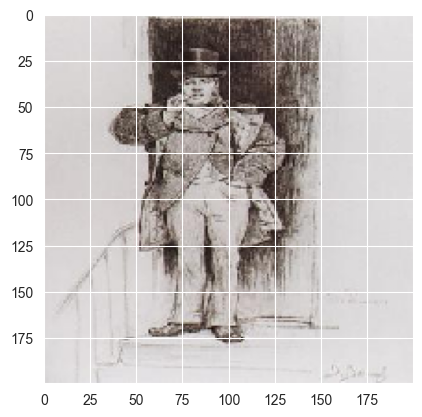

In [31]:
#################################################
#Validate on an image
#img = image.load_img('movie_dataset_multilabel/images/tt4425064.jpg', target_size=(SIZE,SIZE,3))
os.chdir(image_directory)
image_idx = 36300
img = image.image_utils.load_img(str(image_idx)+'.jpg', target_size=(SIZE,SIZE,3))

img = image.image_utils.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = np.array(df.columns[5:]) #Get array of all classes
proba = model.predict(img)  #Get probabilities for each class

print(proba)

###################################################

#_, acc = model.evaluate(X_test, y_test)
#print("Accuracy = ", (acc * 100.0), "%")

################################################################

"""
"""





In [32]:
print(df.loc[image_idx,:])

Artwork                                                          From Dominik
Artist                                                       Viktor Vasnetsov
Link                        https://uploads4.wikiart.org/images/viktor-vas...
Style_Baroque                                                               0
Style_Expressionism                                                         0
Style_Impressionism                                                         0
Style_Neoclassicism                                                         0
Style_Post-Impressionism                                                    0
Style_Realism                                                               1
Style_Romanticism                                                           0
Style_Surrealism                                                            0
Style_Symbolism                                                             0
Date_1580                                                       

244/244 [==============================] - 28s 113ms/step
[[258 105  91   0  67  15 185  44  10]
 [ 19 503  51   0 198   6  38 167  33]
 [ 23 191 281   0 345  11  42  24  15]
 [114  66  62   0  32  11 124  87   7]
 [ 16 364 109   0 428   7  27  69  11]
 [ 78 136 250   0 122  32 213  38  13]
 [110 106 192   0  64  33 296  54  20]
 [ 22 390  46   0 127   5  54 257  41]
 [ 21 232 148   0 232  12  79  40  87]]


[Text(0, 0.5, 'Style_Baroque'),
 Text(0, 1.5, 'Style_Expressionism'),
 Text(0, 2.5, 'Style_Impressionism'),
 Text(0, 3.5, 'Style_Neoclassicism'),
 Text(0, 4.5, 'Style_Post-Impressionism'),
 Text(0, 5.5, 'Style_Realism'),
 Text(0, 6.5, 'Style_Romanticism'),
 Text(0, 7.5, 'Style_Surrealism'),
 Text(0, 8.5, 'Style_Symbolism')]

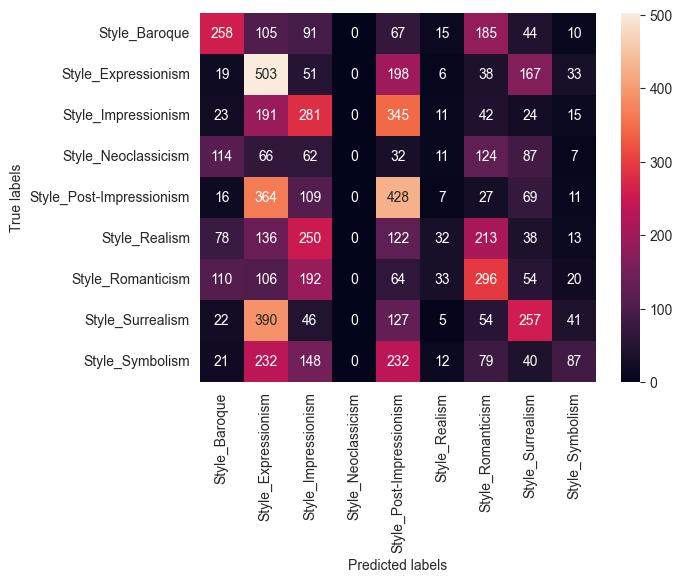

In [44]:
# COnfusion Matrix
from sklearn.metrics import confusion_matrix

test1_predictions, test2_predictions = model.predict(X_test)
cm_style = confusion_matrix(y1_test.argmax(axis=1),test1_predictions.argmax(axis=1))
print(cm_style)

import seaborn as sns

# Plot Style Confusion Matrix
ax=plt.subplot()
sns.heatmap(cm_style, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
style_labels = ["Style_Baroque", "Style_Expressionism", "Style_Impressionism", "Style_Neoclassicism", "Style_Post-Impressionism",
    "Style_Realism", "Style_Romanticism", "Style_Surrealism", "Style_Symbolism"]
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
ax.set_xlabel("Predicted labels"); ax.set_ylabel("True labels")
ax.xaxis.set_ticklabels(style_labels); ax.yaxis.set_ticklabels(style_labels)

ValueError: The number of FixedLocator locations (15), usually from a call to set_ticks, does not match the number of ticklabels (30).

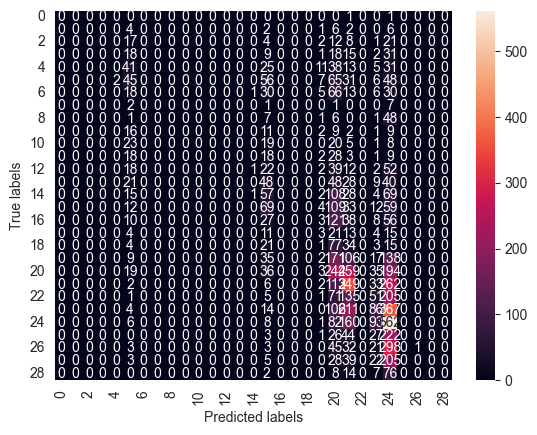

In [43]:


# Plot decades confusion
cm_decades = confusion_matrix(y2_test.argmax(axis=1),test2_predictions.argmax(axis=1))
ax=plt.subplot()
sns.heatmap(cm_decades, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
ax.set_xlabel("Predicted labels"); ax.set_ylabel("True labels")
ax.xaxis.set_ticklabels(decades); ax.yaxis.set_ticklabels(decades)

In [35]:
df[["Style_Baroque", "Style_Expressionism", "Style_Impressionism", "Style_Neoclassicism", "Style_Post-Impressionism",
    "Style_Realism", "Style_Romanticism", "Style_Surrealism", "Style_Symbolism"]].apply(pd.Series.value_counts)

,Style_Baroque,Style_Expressionism,Style_Impressionism,Style_Neoclassicism,Style_Post-Impressionism,Style_Realism,Style_Romanticism,Style_Surrealism,Style_Symbolism
0,23412,22618,22766,24371,22675,23158,23061,22868,23207
1,2605,3399,3251,1646,3342,2859,2956,3149,2810


In [48]:
df[decades].apply(pd.Series.value_counts)

,Date_1580,Date_1590,Date_1600,Date_1610,Date_1620,Date_1630,Date_1640,Date_1730,Date_1740,Date_1750,...,Date_1860,Date_1870,Date_1880,Date_1890,Date_1900,Date_1910,Date_1920,Date_1930,Date_1940,Date_1950
0,26005,25941,25821,25709,25451,25113,25474,26016,25983,25804,...,24525,23336,23412,24529,23357,22935,24934,24666,25051,25642
1,12,76,196,308,566,904,543,1,34,213,...,1492,2681,2605,1488,2660,3082,1083,1351,966,375


In [ ]:
# Two separate models
newModel = True
if newModel:
    input_layer = Input(shape=(SIZE,SIZE,3))

    conv1 = Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(input_layer)
    bn1 = BatchNormalization()(conv1)
    mp1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    dropout1 = Dropout(0.2)(mp1)

    conv2 = Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(dropout1)
    mp2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    bn2 = BatchNormalization()(mp2)
    dropout2 = Dropout(0.2)(bn2)

    conv3 = Conv2D(filters=64, kernel_size=(5, 5), activation="relu")(dropout2)
    mp3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    bn3 = BatchNormalization()(mp3)
    dropout3 = Dropout(0.2)(bn3)

    conv4 = Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(dropout3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    bn4 = BatchNormalization()(mp4)
    dropout4 = Dropout(0.2)(bn4)

    flatten = Flatten()(dropout4)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout5 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout5)
    dropout6 = Dropout(0.5)(dense2)

    y1_output = Dense(len(styles), activation='softmax', name='style_output')(dropout6)
    y2_output = Dense(len(decades), activation='softmax', name='decade_output')(dropout6)
    #model.add(Dense(len(styles)+len(decades), activation='sigmoid')) # changed from 25 to 1 so I get no error

    model_style = keras.Model(inputs=input_layer, outputs=y1_output)
    model_time = keras.Model(inputs=input_layer, outputs=y2_output)


    model_style.summary()
    model_time.summary()


    #Binary cross entropy of each label. So no really a binary classification problem but
    #Calculating binary cross entropy for each label.
    model_style.compile(optimizer='adam',
                  loss={'style_output':'binary_crossentropy', 'decade_output':'binary_crossentropy'},
                  metrics={'style_output':'accuracy','decade_output':'accuracy'})


    history_style = model_style.fit(X_train,
                        y_train[:,0:len(styles)],
                        epochs=5,
                        validation_data=(X_test, y_test[:,0:len(styles)]),
                        batch_size=64,
                        callbacks=[csv_logger])

    # save model
    !mkdir -p saved_model
    model_style.save('saved_model/style_model')

else:
    model = keras.models.load_model('saved_model/my_model_with_years')
    #history = model.evaluate(X_test, y_test, verbose=2)
    #history.history=history